# 04 - Kanton Zürich Wärmenutzungsatlas - Gewässerzonen
### Author: Daniel Herrera-Russert
#### February 03, 2025

In [1]:
# !pip install geopandas owslib requests pyproj fiona

In [32]:
import pandas as pd
import numpy as np
import os

from owslib.wfs import WebFeatureService
import geopandas as gpd
import requests
from io import BytesIO
import fiona

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyproj import Transformer # for converting coordinates

# Set the default renderer for JupyterLab
pio.renderers.default = 'iframe'

## 1. Loading the dataset

We begin with a look at the [Wärmenutzungsatlas](https://maps.zh.ch/?offlayers=bezirkslabels&scale=320000&srid=2056&topic=AwelGSWaermewwwZH&x=2692500&y=1252500) of Kanton Zürich. The data is retrieved from the GIS portal via WFS service, in order to obtain the separate layers preserving the geographic data qualities. Alternatively, it could be downloaded manually directly from the GIS download section in a variety of formats for different purposes.

Following is the extraction and exploration of the dataset, corresponding to the layer containing the water protection zones.

In [2]:
# Define the WFS endpoint
WFS_URL = "https://maps.zh.ch/wfs/AwelGSWaermewwwZHWFS"

# Connect to the WFS service
wfs = WebFeatureService(WFS_URL, version="2.0.0")

# List available layers
print("Available layers:")
for layer in list(wfs.contents):
    print(layer)

Available layers:
ms:waermenutzung-zone-a
ms:waermenutzung-zone-b
ms:waermenutzung-zone-c
ms:waermenutzung-zone-d
ms:waermenutzung-zone-e
ms:waermenutzung-zone-f
ms:erdwaermesonden-auflagen
ms:tunnels-und-stollen
ms:erdwaermesonden
ms:sonden
ms:sammelschacht
ms:grundwasserpiezometer
ms:erdregister
ms:quellfassung-waermenutzung
ms:grundwasserfassung-waermenutzung
ms:quellfassung-ohne-waermenutzung
ms:grundwasserfassung-ohne-waermenutzung


In [16]:
# Define the list of layers to download
layers = [
    "ms:waermenutzung-zone-a",
    "ms:waermenutzung-zone-b",
    "ms:waermenutzung-zone-c",
    "ms:waermenutzung-zone-d",
    "ms:waermenutzung-zone-e",
    "ms:waermenutzung-zone-f",
]

# Define expected CRS (EPSG:2056 - LV95)
expected_crs = "EPSG:2056"

# Define output file
output_gpkg = "data/raw/zh_waermenutzung_zonen.gpkg"

# Loop through layers and save them into a single GeoPackage
for layer in layers:
    print(f"Downloading {layer}...")
    
    # Request data in GML format
    response = wfs.getfeature(typename=layer, outputFormat="GML2")
    
    # Read the response as a GeoDataFrame
    gdf = gpd.read_file(BytesIO(response.read()))
    
    # Check and set CRS if missing
    if gdf.crs is None:
        gdf.set_crs(expected_crs, inplace=True)
    
    # Append each layer into the same GeoPackage
    gdf.to_file(output_gpkg, layer=layer.replace("ms:", ""), driver="GPKG")

print(f"All layers saved into '{output_gpkg}' with CRS {expected_crs}")

All layers saved into 'data/raw/zh_waermenutzung_zonen.gpkg' with CRS EPSG:2056


In [17]:
layers = ["waermenutzung-zone-a",
          "waermenutzung-zone-b",
          "waermenutzung-zone-c", 
          "waermenutzung-zone-d", 
          "waermenutzung-zone-e",
          "waermenutzung-zone-f"]

dfs = [gpd.read_file(geojson_path, layer=layer) for layer in layers]
zh_geothermal_zones_gdf = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))

# Check coordinate system
print(zh_geothermal_zones_gdf.crs)

EPSG:2056


In [18]:
# Display the first few rows of each dataset to verify
zh_geothermal_zones_gdf.head(5)

,gml_id,geometry
0,waermenutzung-zone-a.1,"MULTIPOLYGON (((2685829.327 1249646.519, 26858..."
1,waermenutzung-zone-a.2,"MULTIPOLYGON (((2685737.917 1250003.611, 26857..."
2,waermenutzung-zone-a.3,"MULTIPOLYGON (((2685732.254 1250011.309, 26857..."
3,waermenutzung-zone-a.4,"MULTIPOLYGON (((2685751.834 1249872.674, 26857..."
4,waermenutzung-zone-a.5,"MULTIPOLYGON (((2685853.92 1249946.547, 268584..."


In [30]:
layers = fiona.listlayers(input_gpkg)
print("Available layers:", layers)

Available layers: ['waermenutzung-zone-a', 'waermenutzung-zone-b', 'waermenutzung-zone-c', 'waermenutzung-zone-d', 'waermenutzung-zone-e', 'waermenutzung-zone-f']


C:\Users\leina\AppData\Local\Temp\ipykernel_15772\1293654179.py:18: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler

C:\Users\leina\AppData\Local\Temp\ipykernel_15772\1293654179.py:18: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



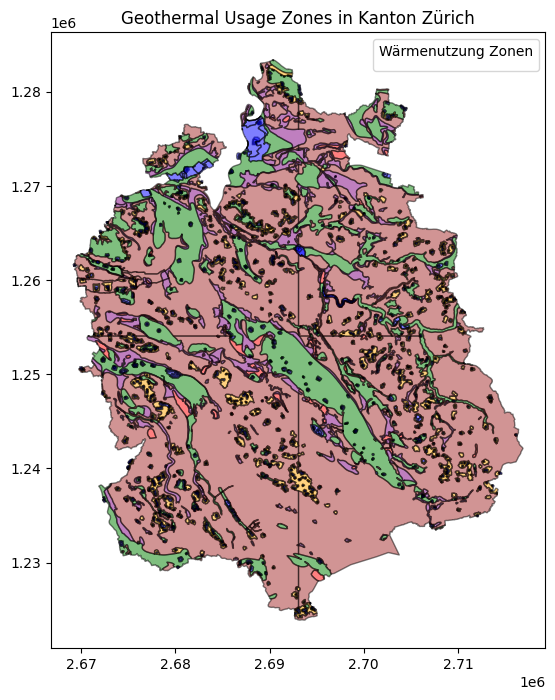

In [33]:
# Define a color map for layers
colors = ["blue", "green", "red", "purple", "orange", "brown"]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Load and plot each layer with a different color
for layer, color in zip(layers, colors):
    gdf = gpd.read_file(input_gpkg, layer=layer)
    
    # Ensure CRS is set
    if gdf.crs is None:
        gdf.set_crs("EPSG:2056", inplace=True)  # Assuming LV95 (Switzerland's official CRS)
    
    gdf.plot(ax=ax, color=color, alpha=0.5, edgecolor="black", label=layer)

# Add legend and title
ax.legend(title="Wärmenutzung Zonen")
ax.set_title("Geothermal Usage Zones in Kanton Zürich")

# Show plot
plt.show()

---

## 2. Exploratory Data Analysis  
